In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import numpy as onp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami
from vittles import solver_lib

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [3]:
# np.random.seed(53453)

# load data

In [7]:
# data_file = '../../../../fastStructure/test/testdata.npz'

data_file = '../../../../fastStructure/hgdp_data/huang2011_plink_files/' + \
                'phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'

data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)


In [8]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# Load fits

In [9]:
import os
import re

In [14]:
fits_dir = '../fits/fits_20201106/'
# filenames = 'testdata_fit_alpha*'
filenames = 'huang2011_fits_alpha*'

In [15]:
files = [f for f in os.listdir(fits_dir) if re.match(filenames, f)]

In [20]:
print(len(files))

16


In [17]:
files

['huang2011_fits_alpha9.5.npz',
 'huang2011_fits_alpha1.0.npz',
 'huang2011_fits_alpha4.5.npz',
 'huang2011_fits_alpha8.5.npz',
 'huang2011_fits_alpha2.0.npz',
 'huang2011_fits_alpha7.5.npz',
 'huang2011_fits_alpha6.5.npz',
 'huang2011_fits_alpha8.0.npz',
 'huang2011_fits_alpha1.5.npz',
 'huang2011_fits_alpha9.0.npz',
 'huang2011_fits_alpha5.0.npz',
 'huang2011_fits_alpha6.0.npz',
 'huang2011_fits_alpha3.5.npz',
 'huang2011_fits_alpha10.0.npz',
 'huang2011_fits_alpha7.0.npz',
 'huang2011_fits_alpha11.0.npz']

### load first fit to get metadata

In [18]:
_, vb_params_paragami, meta_data = \
    paragami.load_folded(fits_dir + files[0])

# logitnormal parameters
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)

use_logitnormal_sticks = meta_data['use_logitnormal_sticks'] == 1

# prior parameters for population beta
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict['allele_prior_alpha'] = np.array(meta_data['allele_prior_alpha'])
prior_params_dict['allele_prior_beta'] = np.array(meta_data['allele_prior_beta'])

### Load all fits

In [19]:
vb_refit_list = []
alpha_vec = onp.zeros(len(files))

for i in range(len(files)): 
    
    print('loading fit from: ', files[i])
    
    # load fit
    vb_params_dict, vb_params_paragami, meta_data = \
        paragami.load_folded(fits_dir + files[i])
    
    # check KL
    prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
    
    kl = structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                                gh_loc, gh_weights)
    
    assert np.abs(kl - meta_data['final_kl']) < 1e-8
    
    # save alpha and fitted parametrs
    alpha_vec[i] = meta_data['dp_prior_alpha']
    vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
alpha_vec = np.array(alpha_vec)
vb_refit_list = np.array(vb_refit_list)

loading fit from:  huang2011_fits_alpha9.5.npz
loading fit from:  huang2011_fits_alpha1.0.npz
loading fit from:  huang2011_fits_alpha4.5.npz
loading fit from:  huang2011_fits_alpha8.5.npz
loading fit from:  huang2011_fits_alpha2.0.npz
loading fit from:  huang2011_fits_alpha7.5.npz
loading fit from:  huang2011_fits_alpha6.5.npz
loading fit from:  huang2011_fits_alpha8.0.npz
loading fit from:  huang2011_fits_alpha1.5.npz
loading fit from:  huang2011_fits_alpha9.0.npz
loading fit from:  huang2011_fits_alpha5.0.npz
loading fit from:  huang2011_fits_alpha6.0.npz
loading fit from:  huang2011_fits_alpha3.5.npz
loading fit from:  huang2011_fits_alpha10.0.npz
loading fit from:  huang2011_fits_alpha7.0.npz
loading fit from:  huang2011_fits_alpha11.0.npz


In [21]:
# for convencience, sort the alphas 
_indx = np.argsort(alpha_vec)
alpha_vec = alpha_vec[_indx]
vb_refit_list = vb_refit_list[_indx]

In [1]:
[3, 4] + [8]

[3, 4, 8]

# Define the initial fit

In [22]:
indx0 = 5

alpha0 = alpha_vec[indx0]
print(alpha0)

vb_opt = vb_refit_list[indx0]
vb_opt_dict = vb_params_paragami.fold(vb_refit_list[indx0], free = True)

5.0


### Plot initial fit

In [23]:
def plot_e_ind_admix(vb_params_dict): 
    e_ind_admix = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0]
    
    # get large clusters
    top_clusters = np.argsort(- e_ind_admix.sum(0))

    # we color the top clusters
    # all else is grey
    n_clusters_plot = 3
    import colorsys
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,n_clusters_plot+1)[:-1]]

    colors_plus_grey = ['grey'] * e_ind_admix.shape[1]

    for i in range(n_clusters_plot): 
        colors_plus_grey[top_clusters[i]] = colors[i]
        
    # re-order individuals for better plotting
    indx = data_utils.cluster_admix_get_indx(e_ind_admix)
    
    # plot!
    f, axarr = plt.subplots(1, 1, figsize=(6, 3))
    plotting_utils.plot_admixture(e_ind_admix[indx], axarr, colors = colors_plus_grey);
    
    return e_ind_admix 

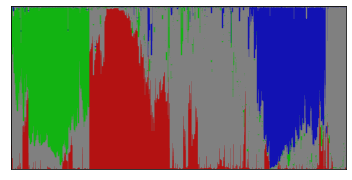

In [24]:
e_ind_admix = plot_e_ind_admix(vb_opt_dict)

### expected number of clusters

In [25]:
key = key = jax.random.PRNGKey(0)

@jax.jit
def get_e_num_pred_clusters(vb_params_dict): 
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                            key, n_samples = 10000)

In [ ]:
get_e_num_pred_clusters(vb_opt_dict)

# Define sensitivity object

In [ ]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha0, 
                                                              free = use_free_alpha)

In [ ]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


### Get hessian solver

In [ ]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_sqrt = False, 
                                            return_info = True)

### Compute VB sensitivity derivatives

In [ ]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0, 
                                                        cg_precond=cg_precond)

# Get linear reponse predictions

In [ ]:
def get_num_clusters_vec(vb_free_params_list, cluster_fun): 
    # vb_free_params_list contains an array of 
    # vb free parameters, where each row contains 
    # parameters from a different refit (or lr prediction)
    
    # cluster fun takes input a vb parameter dictionary 
    # and returns the posterior expectation of interest
    
    n_refit = len(vb_free_params_list)
    n_clusters_vec = onp.zeros(n_refit)
    
    for i in range(n_refit): 
        # fold 
        vb_dict = vb_params_paragami.fold(vb_free_params_list[i], 
                                          free = True)

        # get number of clusters
        n_clusters_vec[i] = cluster_fun(vb_dict)
    
    return n_clusters_vec

In [ ]:
def get_lr_predictions(vb_sens, cluster_fun): 

    t0 = time.time()
    lr_free_params_list = []
    for i in range(len(alpha_vec)): 
    
        # get lr predicted parameters
        alpha_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha_vec[i],
                                                                     free = use_free_alpha)

        lr_free = vb_sens.predict_opt_par_from_hyper_par(alpha_pert)
        
        lr_free_params_list.append(lr_free)
    
    # computing the vb parameters are fast!
    print('lr time: {:03f}secs'.format(time.time() - t0))
    
    # actually computing the posterior quantity can be slow
    return get_num_clusters_vec(lr_free_params_list, cluster_fun)

In [ ]:
lr_n_clusters_vec = get_lr_predictions(vb_sens, get_e_num_pred_clusters)

# compare against refit results

In [ ]:
refit_n_clusters_vec = get_num_clusters_vec(vb_refit_list, get_e_num_pred_clusters)

In [ ]:
plt.plot(alpha_vec, lr_n_clusters_vec, '+--')
plt.plot(alpha_vec, refit_n_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(alpha0, color = 'red', linestyle = 'dashed')

# Start from a different alpha

In [ ]:
indx0 = 10

alpha1 = alpha_vec[indx0]
print(alpha1)

vb_opt = vb_refit_list[indx0]
vb_opt_dict = vb_params_paragami.fold(vb_refit_list[indx0], free = True)

_ = plot_e_ind_admix(vb_opt_dict)

In [ ]:
# reset sensitivity derivatives 

t0 = time.time()
vb_sens.set_derivatives(vb_opt, 
                        prior_params_paragami['dp_prior_alpha'].flatten(alpha1, 
                                                              free = use_free_alpha))
print(time.time() - t0)

In [ ]:
# get new predictions
lr_n_clusters_vec1 = get_lr_predictions(vb_sens, get_e_num_pred_clusters)

In [ ]:
plt.plot(alpha_vec, lr_n_clusters_vec1, '+--')
plt.plot(alpha_vec, refit_n_clusters_vec, '+-')


plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(alpha1, color = 'red', linestyle = 'dashed')

# Start from a different alpha (again)

In [ ]:
indx0 = 17

alpha2 = alpha_vec[indx0]
print(alpha2)

vb_opt = vb_refit_list[indx0]
vb_opt_dict = vb_params_paragami.fold(vb_refit_list[indx0], free = True)

_ = plot_e_ind_admix(vb_opt_dict)

In [ ]:
# reset sensitivity derivatives 

t0 = time.time()
vb_sens.set_derivatives(vb_opt, 
                        prior_params_paragami['dp_prior_alpha'].flatten(alpha2, 
                                                              free = use_free_alpha))
print(time.time() - t0)

In [ ]:
# get new predictions
lr_n_clusters_vec2 = get_lr_predictions(vb_sens, get_e_num_pred_clusters)

In [ ]:
plt.plot(alpha_vec, lr_n_clusters_vec2, '+--')
plt.plot(alpha_vec, refit_n_clusters_vec, '+-')


plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(alpha2, color = 'red', linestyle = 'dashed')

# the final plot!

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize = (15, 4))

for i in range(3): 
    axarr[i].plot(alpha_vec, refit_n_clusters_vec, '+-', label = 'refit')
    axarr[i].set_xlabel('alpha')
    axarr[i].set_ylabel('num clusters')

    
axarr[0].plot(alpha_vec, lr_n_clusters_vec, '+--')
axarr[0].axvline(alpha0, color = 'red')

axarr[1].plot(alpha_vec, lr_n_clusters_vec1, '+--')
axarr[1].axvline(alpha1, color = 'red')

axarr[2].plot(alpha_vec, lr_n_clusters_vec2, '+--', label = 'lr')
axarr[2].axvline(alpha2, color = 'red')

axarr[2].legend()

In [ ]:
# for loading in an already saved hessian inverse solution ... 

# class VBSensitivity(object): 
#     def __init__(self, lr_file, opt_par_value, hyper_par_value0): 
#         self.dinput_dhyper = np.load(lr_file)
        
#         self.opt_par_value = opt_par_value
#         self.hyper_par_value0 = hyper_par_value0
        
#     def predict_opt_par_from_hyper_par(self, hyper_par_value):
#         delta = (hyper_par_value - self.hyper_par_value0)

#         if len(self.dinput_dhyper.shape) == 1:
#             self.dinput_dhyper = np.expand_dims(self.dinput_dhyper, 1)

#         return np.dot(self.dinput_dhyper, delta) + self.opt_par_value

In [ ]:
# load_lr_der = True
# if load_lr_der: 
#     lr_file = fit_dir + 'alpha_sens_nobs{}_nloci{}_npop{}_alpha{}.npy'.format(n_obs, 
#                                                                           n_loci, 
#                                                                           n_pop, 
#                                                                           alpha0)
#     vb_sens = VBSensitivity(lr_file, vb_opt, prior_alpha0)
# else: 
#     vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
#                                                         vb_opt,
#                                                         prior_alpha0, 
#                                                         cg_precond=cg_precond)

In [ ]:
# def e_num_clusters_from_ez(vb_params_dict, gh_loc, gh_weights): 
#     e_log_sticks, e_log_1m_sticks, \
#         e_log_pop_freq, e_log_1m_pop_freq = \
#             structure_model_lib.get_moments_from_vb_params_dict(vb_params_dict,
#                                     gh_loc = gh_loc,
#                                     gh_weights = gh_weights)
#     e_log_cluster_probs = \
#         modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
#                             e_log_sticks, e_log_1m_sticks)
    
    
#     prod_ez = 1.
#     for l in range(g_obs.shape[1]):
#         _, e_z_l = structure_model_lib.get_optimal_ezl(g_obs[:, l],
#                                 e_log_pop_freq[l], e_log_1m_pop_freq[l],
#                                 e_log_cluster_probs)
        
#         prod_ez *= (1 - e_z_l).prod(2).prod(0)
                
#     return prod_ez